# Unbinned Profiled Unfolding

In [1]:
%load_ext tensorboard
import os, sys
import datetime
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
from tqdm import tqdm
from sklearn.metrics import accuracy_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu" if torch.cuda.is_available() else "cpu"
# dvc=device="cpu"
print(f"Using {device} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu device


In [25]:
# Data sets for training W0 and training W1

class w0_dataset(Dataset):
    def __init__(self, T, R):
        super(w0_dataset, self).__init__()
        
        self.R = R
        self.T = T
        
    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.from_numpy(self.T[idx]), torch.from_numpy(self.R[idx])
    
class w1_dataset(Dataset):
    def __init__(self, T0, R0, T1, R1, theta0, theta1):
        super(w1_dataset, self).__init__()
        
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.R0 = R0
        self.T0 = T0
        self.R1 = R1
        self.T1 = T1
        self.theta0 = theta0
        self.theta1 = theta1
        self.inds = np.random.randint(0,len(R1),len(R0))
                
    def __len__(self):
        return len(self.R0)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 1:
            return self.R1[self.inds[i]], self.T0[i], self.T1[self.inds[i]], torch.tensor([self.theta0[i]]), torch.tensor([self.theta1[self.inds[i]]]), torch.tensor([label])
        else:
            return self.R0[i], self.T0[i], self.T1[self.inds[i]], torch.tensor([self.theta0[i]]), torch.tensor([self.theta1[self.inds[i]]]), torch.tensor([label])
        
class w1_dataset_2(Dataset):
    def __init__(self, T0, R0, T1, R1, theta0, theta1):
        super(w1_dataset_2, self).__init__()
        
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.R0 = R0
        self.T0 = T0
        self.R1 = R1
        self.T1 = T1
        self.theta0 = theta0
        self.theta1 = theta1
        self.inds = np.random.randint(0,len(R1),len(R0))
                
    def __len__(self):
        return len(self.R0)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 1:
            return self.R1[self.inds[i]], self.T1[self.inds[i]], torch.tensor([self.theta1[self.inds[i]]]), torch.tensor([label])
        else:
            return self.R0[i], self.T0[i], torch.tensor([self.theta0[i]]), torch.tensor([label])

In [26]:
# Loss function (NLL)

class NLLLoss(nn.Module):

    def __init__(self, obs_data, bins, normalize=False, device="cpu"):
        super(NLLLoss, self).__init__()
        self.normalize = normalize
        self.dvc = device
        if type(obs_data) == torch.Tensor:
            self.obs_data = obs_data.float().to(self.dvc)
        elif type(obs_data) == np.ndarray:
            self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
        elif type(obs_data) == list:
            self.obs_data = torch.tensor(obs_data).float().to(self.dvc)
        if type(bins) == torch.Tensor:
            self.bins = bins.float().to(self.dvc)
        elif type(bins) == np.ndarray:
            self.bins = torch.from_numpy(bins).float().to(self.dvc)
        elif type(bins) == list:
            self.bins = torch.tensor(bins).float().to(self.dvc)
        self.h_obs_data = torch.tensor([(torch.bucketize(self.obs_data, self.bins)==i).sum() for i in range(1, len(self.bins))]).to(self.dvc)
        self.y_obs_data = len(self.obs_data)
        
    def forward(self, R, weights, theta):
        h_R = None
        for i in range(1, len(self.bins)):
            h_R_i = torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1)
            h_R = torch.cat((h_R, h_R_i)) if h_R != None else h_R_i
        if self.normalize: h_R = h_R * self.y_obs_data / h_R.sum()
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(torch.sub(torch.mul(self.h_obs_data, torch.log(h_R)), h_R).sum(), log_gauss))
        return nll

class NLLLoss_2D(nn.Module):

    def __init__(self, obs_data, bins1, bins2, device="cpu"):
        super(NLLLoss_2D, self).__init__()
        self.dvc = device
        self.h_obs_data = np.array([[((np.digitize(obs_data[:,0], bins1)==i) * (np.digitize(obs_data[:,1], bins2)==j)).sum() for j in range(1, len(bins2))] for i in range(1, len(bins1))])
        if type(bins1) == torch.Tensor:
            self.bins1 = bins.float().to(self.dvc)
        elif type(bins1) == np.ndarray:
            self.bins1 = torch.from_numpy(bins1).float().to(self.dvc)
        elif type(bins1) == list:
            self.bins1 = torch.tensor(bins1).float().to(self.dvc)
        if type(bins2) == torch.Tensor:
            self.bins2 = bins2.float().to(self.dvc)
        elif type(bins2) == np.ndarray:
            self.bins2 = torch.from_numpy(bins2).float().to(self.dvc)
        elif type(bins2) == list:
            self.bins2 = torch.tensor(bins2).float().to(self.dvc)
        self.y_obs_data = len(obs_data)
        
    def forward(self, R, weights, theta):
        nll = 0
        for i in range(1, len(self.bins1)):
            for j in range(1, len(self.bins2)):
                h_R_ij = torch.matmul(torch.transpose((torch.bucketize(R, self.bins1)==i).double()*weights.reshape(-1,1), 0, 1), (torch.bucketize(R, self.bins2)==j).double())[0,1]#.reshape(1,1)
                if h_R_ij > 0:
                    nll += self.h_obs_data[i-1, j-1]*torch.log(h_R_ij) - h_R_ij
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(nll, log_gauss))
        return nll

In [27]:
# All the networks (W0, W1 and theta)

class w0_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=False, std_params=None):
        super(w0_network, self).__init__()
            
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(1 if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T):
        if std_params: T = (T-self.std_params[0])/self.std_params[1]
        logit = self.linear_relu_stack(T)
        if self.sigmoid:
            return logit / (1 - logit)
        else:
            return torch.exp(logit)
        
class w0_dummy(nn.Module):
    def __init__(self):
        super(w0_dummy, self).__init__()
        
    def forward(self, T):
        return 1
    
class w1_analytic(nn.Module):  
    def __init__(self, epsilon, beta, d, delta_epsilon=0):
        super(w1_analytic, self).__init__()
        self.epsilon = epsilon
        self.delta_epsilon = delta_epsilon
        self.beta = beta
        self.d = d
        
    def forward(self, T, R, theta, theta0=None, T1=None):
        c = theta * self.delta_epsilon + self.epsilon
        return (self.epsilon/c)*torch.exp(-0.5*(R-T-self.d)**2/c**2+0.5*(R-T-self.beta)**2/self.epsilon**2)
    
class w1_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None, n_inputs=6):
        super(w1_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        self.n_inputs = n_inputs
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(self.n_inputs if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        # self.loss_fn = nn.BCELoss()
        
    def forward(self, T0, R, theta1, theta0, T1):
        T0 = (T0-self.std_params[0])/self.std_params[1]
        T1 = (T1-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
        x = torch.cat([R, T0, theta0, T1, theta1], dim=1)
#         x = torch.cat([R, T0, T1], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return (logit) / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)
        
class w1T_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None, n_inputs=2):
        super(w1T_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        self.n_inputs = n_inputs
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(self.n_inputs if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        # self.loss_fn = nn.BCELoss()
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        x = torch.cat([T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return (logit) / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)
        
class w1RT_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None, n_inputs=4):
        super(w1RT_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        self.n_inputs = n_inputs
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(self.n_inputs if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        # self.loss_fn = nn.BCELoss()
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
        x = torch.cat([R, T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return (logit) / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)
    
class theta_module(nn.Module):
    def __init__(self, init_value=0.):
        super(theta_module, self).__init__()
        self.theta = nn.Parameter(torch.ones(1) * init_value)
        
    def forward(self):
        return self.theta


In [35]:
# training and testing utilities

def train_w1_2(train_dataloader, val_dataloader, model_w1, loss_fn, optimizer, max_epoch=1000, patience=10):
    
    print("===================== Model W1 =====================")
    print(model_w1)
    
    best_state = model_w1.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w1.train()
        for batch, (R, T, theta, label) in enumerate(train_dataloader):
            R, T, theta, label = R.to(dvc), T.to(dvc), theta.to(dvc), label.to(dvc)

            W = model_w1(T, R, theta)
            logit = W/(W + 1)
            loss = loss_fn(logit, label.double())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
        # now evaluate performance at the epoch end
        model_w1.eval()
        
        # evaluate loss for traing set
        Ws, labels = None, None
        with torch.no_grad():
            for batch, (R, T, theta, label) in enumerate(train_dataloader):
                R, T, theta, label = R.to(dvc), T.to(dvc), theta.to(dvc), label.to(dvc)

                W = model_w1(T, R, theta)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            train_loss = loss_fn(logits, labels.double())
            
        # evaluate loss for validation set
        Ws, labels = None, None
        with torch.no_grad():
            for batch, (R, T, theta, label) in enumerate(val_dataloader):
                R, T, theta, label = R.to(dvc), T.to(dvc), theta.to(dvc), label.to(dvc)

                W = model_w1(T, R, theta)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            val_loss = loss_fn(logits, labels.double())
        
        print("\r" + " "*(50), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w1.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            model_w1.load_state_dict(best_state)
            break
            
def test_w1_2(test_dataloader, model_w1RT, model_w1T, theta):
       
    # now evaluate performance at the epoch end
    model_w1RT.eval()
    model_w1T.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W1 = model_w1RT(T, R, ones*theta)/model_w1T(T, R, ones*theta)
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

def train_w0_2(train_dataloader, val_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn, optimizer, optimizer1=None, max_epoch=1000, patience=10):
    
    print("===================== Model W0 =====================")
    print(model_w0)
    print("===================== Model W1RT =====================")
    print(model_w1RT)
    print("===================== Model W1T =====================")
    print(model_w1T)
    print(f"Initial theta: {model_theta().item()}")
    
    model_w1RT.eval()
    model_w1T.eval()
    
    best_state = model_w0.state_dict()
    best_theta = model_theta.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    print("====================================================")
    print(" Start optimizing the W0 model and theta")
    print("====================================================")
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w0.train()
        model_theta.train()
        for batch, (T, R) in enumerate(train_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            theta = model_theta()[0]
            W = model_w0(T) * model_w1RT(T, R, ones*theta) / model_w1T(T, R, ones*theta)
            loss = loss_fn(R, W, theta)

            # Backpropagation
            optimizer.zero_grad()
            if optimizer1 != None:
                optimizer1.zero_grad()
            loss.backward()
            optimizer.step()
            if optimizer1 != None:
                optimizer1.step()
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}] [Theta: {model_theta().item()}]", end="")
        
        # now evaluate performance at the epoch end
        model_w0.eval()
        model_theta.eval()
        
        # evaluate loss for traing set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(train_dataloader):
                T, R = T.to(dvc), R.to(dvc)
                ones = torch.ones(len(R), 1).to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1RT(T, R, ones*theta) / model_w1T(T, R, ones*theta)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            train_loss = loss_fn(Rs, Ws, theta)
            
        # evaluate loss for validation set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(val_dataloader):
                T, R = T.to(dvc), R.to(dvc)
                ones = torch.ones(len(R), 1).to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1RT(T, R, ones*theta) / model_w1T(T, R, ones*theta)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            val_loss = loss_fn(Rs, Ws, theta)
        
        print("\r" + " "*(80), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}] [Theta: {model_theta().item()}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w0.state_dict())
            best_theta = copy.deepcopy(model_theta.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            print(f"Fitted theta: {theta_model().item()}")
            model_w0.load_state_dict(best_state)
            model_theta.load_state_dict(best_theta)
            break
            
    return best_val_loss
        
        
def test_w0_2(test_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()
    model_w1RT.eval()
    model_w1T.eval()
    model_theta.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W0 = model_w0(T)
            theta = model_theta()[0]
#             W0 = torch.tensor(1.0)
            W1 = model_w1RT(T, R, ones*theta) / model_w1T(T, R, ones*theta)
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws, theta)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s

def train_w1(train_dataloader, val_dataloader, model_w1, loss_fn, optimizer, max_epoch=1000, patience=10):
    
    print("===================== Model W1 =====================")
    print(model_w1)
    
    best_state = model_w1.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w1.train()
        for batch, (R, T0, T1, theta0, theta1, label) in enumerate(train_dataloader):
            R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

            W = model_w1(T0, R, theta1, theta0, T1)
            logit = W/(W + 1)
            loss = loss_fn(logit, label.double())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
        # now evaluate performance at the epoch end
        model_w1.eval()
        
        # evaluate loss for traing set
        Ws, labels = None, None
        with torch.no_grad():
            for batch, (R, T0, T1, theta0, theta1, label) in enumerate(train_dataloader):
                R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

                W = model_w1(T0, R, theta1, theta0, T1)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            train_loss = loss_fn(logits, labels.double())
            
        # evaluate loss for validation set
        Ws, labels = None, None
        with torch.no_grad():
            for batch, (R, T0, T1, theta0, theta1, label) in enumerate(val_dataloader):
                R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

                W = model_w1(T0, R, theta1, theta0, T1)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            val_loss = loss_fn(logits, labels.double())
        
        print("\r" + " "*(50), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w1.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            model_w1.load_state_dict(best_state)
            break
            
def test_w1p(test_dataloader, model_w1):
    
    model_w1.eval()
    Ws, labels = None, None
    Rs, T0s, T1s, theta0s, theta1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (R, T0, T1, theta0, theta1, label) in enumerate(test_dataloader):
            R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

            W = model_w1(T0, R, theta1, theta0, T1)
            Ws = torch.cat([Ws, W]) if Ws is not None else W
            labels = torch.cat([labels, label]) if labels is not None else label
            
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            T0s = torch.cat([T0s, T0]) if T0s is not None else T0
            T1s = torch.cat([T1s, T1]) if T1s is not None else T1
            theta0s = torch.cat([theta0s, theta0]) if theta0s is not None else theta0
            theta1s = torch.cat([theta1s, theta1]) if theta1s is not None else theta1
            
        logits = Ws/(Ws + 1)
        test_loss = loss_fn(logits, labels.double())
#         test_auc = roc_auc(logits.cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1))
    print("\r" + f"[Test_loss: {test_loss:>7f}]")
    return logits.cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1), Rs.cpu().numpy(), T0s.cpu().numpy(), T1s.cpu().numpy(), theta0s.cpu().numpy(), theta1s.cpu().numpy()
            
def test_w1(test_dataloader, model_w1, theta):
       
    # now evaluate performance at the epoch end
    model_w1.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W1 = model_w1(T, R, ones*theta, ones*theta, T)
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

def train_w0(train_dataloader, val_dataloader, model_w0, model_w1, model_theta, loss_fn, optimizer, optimizer1=None, max_epoch=1000, patience=10):
    
    print("===================== Model W0 =====================")
    print(model_w0)
    print("===================== Model W1 =====================")
    print(model_w1)
    print(f"Initial theta: {model_theta().item()}")
    
    model_w1.eval()
    
    best_state = model_w0.state_dict()
    best_theta = model_theta.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    print("====================================================")
    print(" Start optimizing the W0 model and theta")
    print("====================================================")
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w0.train()
        model_theta.train()
        for batch, (T, R) in enumerate(train_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            theta = model_theta()[0]
            W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
            loss = loss_fn(R, W, theta)

            # Backpropagation
            optimizer.zero_grad()
            if optimizer1 != None:
                optimizer1.zero_grad()
            loss.backward()
            optimizer.step()
            if optimizer1 != None:
                optimizer1.step()
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}] [Theta: {model_theta().item()}]", end="")
        
        # now evaluate performance at the epoch end
        model_w0.eval()
        model_theta.eval()
        
        # evaluate loss for traing set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(train_dataloader):
                T, R = T.to(dvc), R.to(dvc)
                ones = torch.ones(len(R), 1).to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            train_loss = loss_fn(Rs, Ws, theta)
            
        # evaluate loss for validation set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(val_dataloader):
                T, R = T.to(dvc), R.to(dvc)
                ones = torch.ones(len(R), 1).to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            val_loss = loss_fn(Rs, Ws, theta)
        
        print("\r" + " "*(80), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}] [Theta: {model_theta().item()}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w0.state_dict())
            best_theta = copy.deepcopy(model_theta.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            print(f"Fitted theta: {theta_model().item()}")
            model_w0.load_state_dict(best_state)
            model_theta.load_state_dict(best_theta)
            break
            
    return best_val_loss
        
        
def test_w0(test_dataloader, model_w0, model_w1, model_theta, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()
    model_w1.eval()
    model_theta.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W0 = model_w0(T)
            theta = model_theta()[0]
#             W0 = torch.tensor(1.0)
            W1 = model_w1(T, R, ones*theta, ones*theta, T)
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws, theta)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s

In [22]:
# Visualization

class comparison_plots_with_ratio:
    
    def __init__(self, xmin, xmax, nbins, xlabel=r"$T$", header="Gaussian Example", density=True, save_name=None):
        
        self.xmin = xmin
        self.xmax = xmax
        self.nbins = nbins
        self.density = density
        self.save_name = save_name
        self.nTt = None
        self.bTt = None
        self.nTs = []
        self.bTs = []
        self.argss = []
        
        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        
        self.ax0 = plt.subplot(gs[0])
        self.ax0.yaxis.set_ticks_position('both')
        self.ax0.xaxis.set_ticks_position('both')
        self.ax0.tick_params(direction="in", which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        self.ax0.minorticks_on()
        
        plt.ylabel("Normalized to Unity" if self.density else "Events", fontsize=20)
        plt.xlim([xmin,xmax])
        plt.title(header,loc="right",fontsize=20, fontstyle="italic")
        
        self.ax1 = plt.subplot(gs[1])
        self.ax1.yaxis.set_ticks_position('both')
        self.ax1.xaxis.set_ticks_position('both')
        self.ax1.tick_params(direction="in",which="both")
        self.ax1.minorticks_on()
        
        plt.xlim([xmin,xmax])
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(xlabel,fontsize=20)
        plt.ylabel("Data/Pred.",fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=15)
        plt.axhline(y=1,linewidth=2, color='gray')   
        plt.ylim(0.5,1.5)
        
    def add_data(self, data, label, target=False, weights=None, histtype=None, color=None, ls=None, lw=None, alpha=None):
        args = {"label": label}
        if type(weights) != type(None): args["weights"] = weights
        if type(histtype) != type(None): args["histtype"] = histtype
        if type(color) != type(None): args["color"] = color
        if type(ls) != type(None): args["ls"] = ls
        if type(lw) != type(None): args["lw"] = lw
        if type(alpha) != type(None): args["alpha"] = alpha
        nT, bT, _ = self.ax0.hist(data, bins=np.linspace(self.xmin, self.xmax, self.nbins), density=self.density, **args)
        if target:
            self.nTt = nT
            self.bTt = bT
        else:
            self.nTs.append(nT)
            self.bTs.append(bT)
            self.argss.append(args)
        
    def plot_ratio(self):
        if type(self.nTt) == type(None):
            return
        for nT, bT, _args in zip(self.nTs, self.bTs, self.argss):
            args = {}
            if "color" in _args: args["color"] = _args["color"]
            if "ls" in _args: args["ls"] = _args["ls"]
            self.ax1.plot(0.5*(self.bTt[1:]+self.bTt[:-1]),self.nTt/(0.000001+nT), **args)
            
    def save(self):
        if type(self.save_name) == type(None):
            return
        os.makedirs("plot", exist_ok=True)
        if os.path.isfile(f"plot/{self.save_name}.pdf"):
            i = 0
            while os.path.isfile(f"plot/{self.save_name}_{i}.pdf"):
                i += 1
            self.save_name = f"{self.save_name}_{i}"
        plt.savefig(f"plot/{self.save_name}.pdf", bbox_inches='tight')
    
    def show(self):
        self.plot_ratio()
        self.ax0.locator_params(axis='y', nbins=6)
        self.ax0.legend(frameon=False,fontsize=20, loc="upper left")
        self.save()
        plt.show()
        plt.clf()

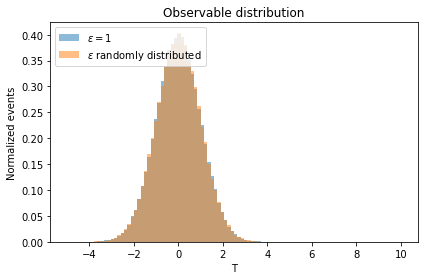

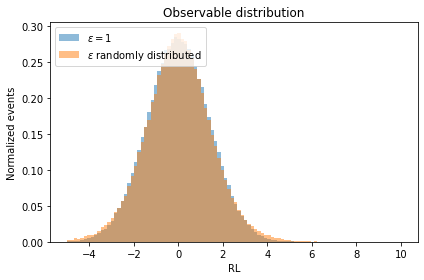

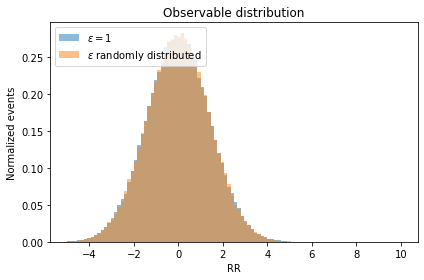

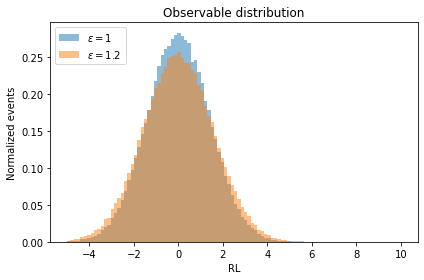

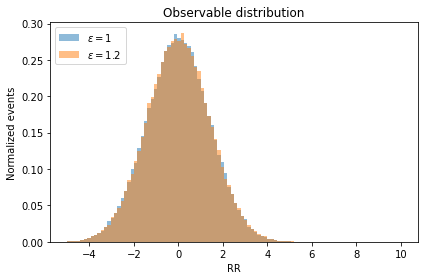

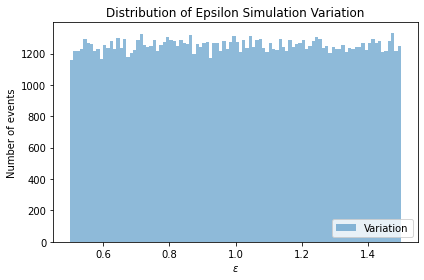

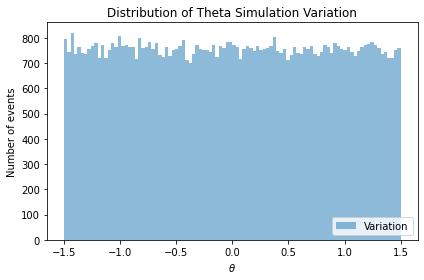

In [23]:
# Generate toy data for W1 training

Nsim = 200000
Ntest = 100000

# simulation
mu_sim = 0
sigma_sim = 1
alpha_sim = 0
delta_sim = 1
beta_sim = 0
epsilon_sim = 1
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
RL_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)
RR_sim = np.random.normal(T_sim+alpha_sim,delta_sim)

# simulation with theta variation (theta value randomly sampled)
epsilon0_sim = np.random.uniform(0.2, 1.8, Nsim)
epsilon1_sim = np.random.uniform(0.2, 1.8, Nsim) # used for training
# delta_epsilon = 0.8
# epsilon0_sim = np.random.uniform(0.8, 1.2, Nsim)
# epsilon1_sim = np.random.uniform(0.8, 1.2, Nsim) # used for training
delta_epsilon = 0.2
theta0_sim = (epsilon0_sim-epsilon_sim)/delta_epsilon
theta1_sim = (epsilon1_sim-epsilon_sim)/delta_epsilon
RL1_sim = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    RL1_sim.append(np.random.normal(T_sim[i]+beta_sim, epsilon1_sim[i]))
RL1_sim = np.array(RL1_sim)
RR1_sim = np.random.normal(T_sim+alpha_sim,delta_sim)

# test
epsilon_test = 1.2
theta_test = (epsilon_test-epsilon_sim)/delta_epsilon
T_test = np.random.normal(mu_sim,sigma_sim,Ntest).reshape(-1, 1)
RL_test0 = np.random.normal(T_test+beta_sim,epsilon_sim)
RR_test0 = np.random.normal(T_test+alpha_sim,delta_sim)
RL_test1 = np.random.normal(T_test+beta_sim,epsilon_test)
RR_test1 = np.random.normal(T_test+alpha_sim,delta_sim)

plt.hist(T_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(T_test, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('T')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RL_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RL1_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('RL')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RR_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RR1_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('RR')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RL_test0, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RL_test1, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_test}$", alpha=0.5)
plt.xlabel('RL')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RR_test0, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RR_test1, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_test}$", alpha=0.5)
plt.xlabel('RR')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(epsilon1_sim, range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\epsilon$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Epsilon Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

plt.hist(theta1_sim, range=(-1.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Theta Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

In [28]:
# Convert data into W1 dataset, data loaders and create loss function

R_sim = np.concatenate((RL_sim, RR_sim), axis=1)
R1_sim = np.concatenate((RL1_sim, RR1_sim), axis=1)

w1_ds = w1_dataset_2(T_sim, R_sim, T_sim, R1_sim, theta0_sim, theta1_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=64, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=64, shuffle=False, num_workers=12)

loss_fn_RT = nn.BCELoss()
loss_fn_T = nn.BCELoss()

[-0.0016383336611762616, 0.9997421910553675, tensor([-0.0005, -0.0046], device='cuda:0', dtype=torch.float64), tensor([1.4509, 1.4143], device='cuda:0', dtype=torch.float64)]


In [34]:
# Create W1 model and training it!

### PLEASE ENTER A NEW MODEL NAME FOR W1 ###
today = str(datetime.date.today())
w1RT_model_name = f'w1RT_gaussian2D_deltaEpsilon0.2_{today}'
w1T_model_name = f'w1T_gaussian2D_deltaEpsilon0.2_{today}'

w1RT_model_network = w1RT_network(sigmoid=True, std_params=std_params).double().to(dvc)
optimizerRT = optim.Adam(w1RT_model_network.parameters(), lr=0.001)
train_w1_2(w1_dataloader_train, w1_dataloader_test, w1RT_model_network, loss_fn_RT, optimizerRT)

w1T_model_network = w1T_network(sigmoid=True, std_params=std_params).double().to(dvc)
optimizerT = optim.Adam(w1T_model_network.parameters(), lr=0.001)
train_w1_2(w1_dataloader_train, w1_dataloader_test, w1T_model_network, loss_fn_T, optimizerT)

torch.save(w1RT_model_network, f'model/w1/{w1RT_model_name}.pth')
torch.save(w1T_model_network, f'model/w1/{w1T_model_name}.pth')

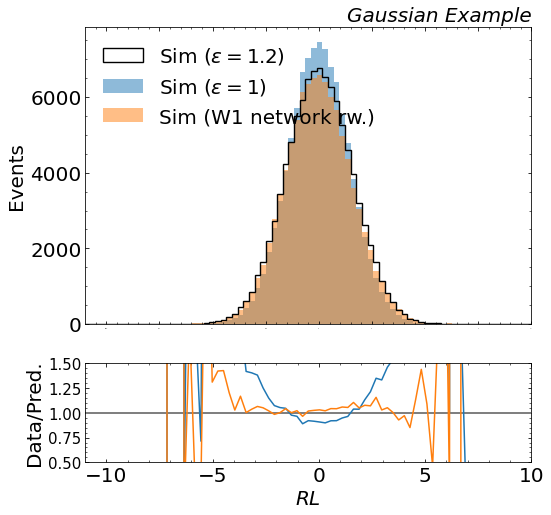

<Figure size 432x288 with 0 Axes>

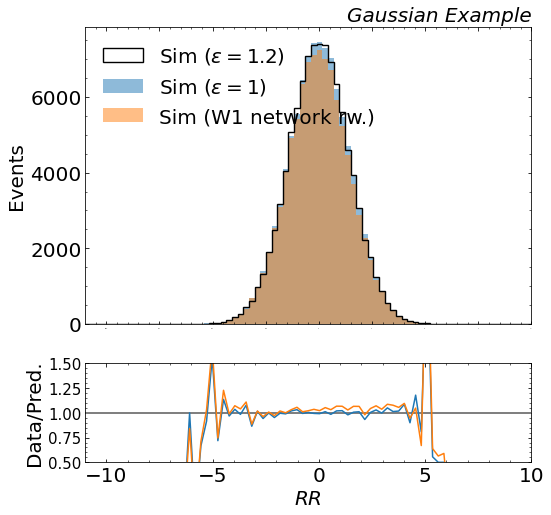

<Figure size 432x288 with 0 Axes>

In [33]:
# Test the trained W1 model

# w1_model_name_0 = 'w1_gaussian2D_deltaEpsilon0.8_2022-11-14'
# w1_model_name_0 = 'w1_gaussian2D_deltaEpsilon0.2_2022-11-15'

# w1_model_network_0 = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)

today = str(datetime.date.today())

R_test0 = np.concatenate((RL_test0, RR_test0), axis=1)
w1_test_ds = w0_dataset(T_test, R_test0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1_2(w1_test_dataloader, w1RT_model_network, w1T_model_network, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"Compare_RL_forW1network2_{today}")
cpwr.add_data(RL_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"Compare_RR_forW1network2_{today}")
cpwr.add_data(RR_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

In [11]:
# Convert data into W1 dataset, data loaders and create loss function

R_sim = np.concatenate((RL_sim, RR_sim), axis=1)
R1_sim = np.concatenate((RL1_sim, RR1_sim), axis=1)

w1_ds = w1_dataset(T_sim, R_sim, T_sim, R1_sim, theta0_sim, theta1_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=64, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=64, shuffle=False, num_workers=12)

loss_fn = nn.BCELoss()

[0.0015532723934743268, 0.9992900829747575, tensor([0.0014, 0.0009], device='cuda:0', dtype=torch.float64), tensor([1.4519, 1.4136], device='cuda:0', dtype=torch.float64)]


In [76]:
# Create W1 model and training it!

### PLEASE ENTER A NEW MODEL NAME FOR W1 ###
today = str(datetime.date.today())
w1_model_name = f'w1_gaussian2D_deltaEpsilon0.2_{today}'

w1_model_network = w1_network(sigmoid=True, std_params=std_params).double().to(dvc)
optimizer = optim.Adam(w1_model_network.parameters(), lr=0.001)
train_w1(w1_dataloader_train, w1_dataloader_test, w1_model_network, loss_fn, optimizer)

torch.save(w1_model_network, f'model/w1/{w1_model_name}.pth')

===================== Model W1 =====================
w1_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=6, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
[Epoch   0] [Train_loss: 0.427128] [Val_loss: 0.427787]
[Epoch   1] [Train_loss: 0.425872] [Val_loss: 0.426790]
[Epoch   2] [Train_loss: 0.422720] [Val_loss: 0.423559]
[Epoch   3] [Train_loss: 0.425778] [Val_loss: 0.426805]
[Epoch   4] [Train_loss: 0.424362] [Val_loss: 0.425183]
[Epoch   5] [Train_loss: 0.421559] [Val_loss: 0.423002]
[Epoch   6] [Train_loss: 0.420973] [Val_loss: 0.422744]
[Epoch   7] [Train_loss: 0.422667] [Val_loss: 0.424620]
[Epoch   8] [Train_loss: 0.420199] [Val_loss: 0.422596]
[Epoch   9] [Train_loss: 0.421395] [

In [15]:
w1_model_name_0 = 'w1_gaussian2D_deltaEpsilon0.2_2022-11-15'

w1_model_network = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)

logits, labels, Rs, T0s, T1s, theta0s, theta1s = test_w1p(w1_dataloader_test, w1_model_network)

[Test_loss: 0.422663]


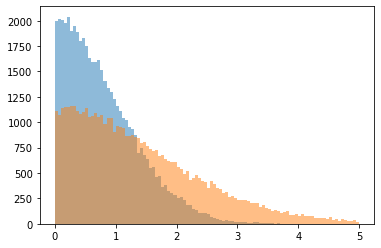

In [17]:
plt.hist(Rs[:,0][labels==0]-T0s[:,0][labels==0], range=(0, 5), density=False, bins=100, label="Variation", alpha=0.5);
plt.hist(Rs[:,0][labels==1]-T0s[:,0][labels==1], range=(0, 5), density=False, bins=100, label="Variation", alpha=0.5);

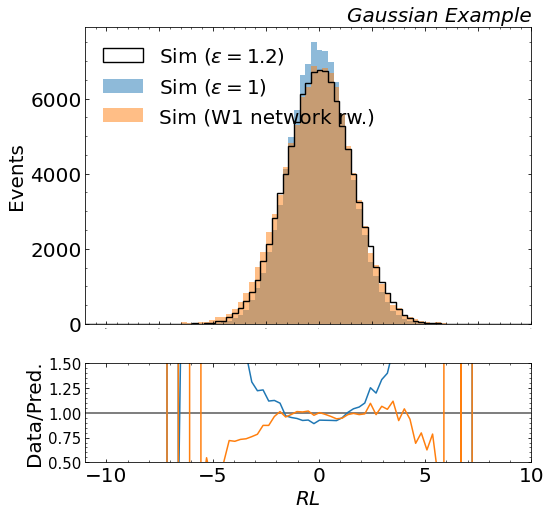

<Figure size 432x288 with 0 Axes>

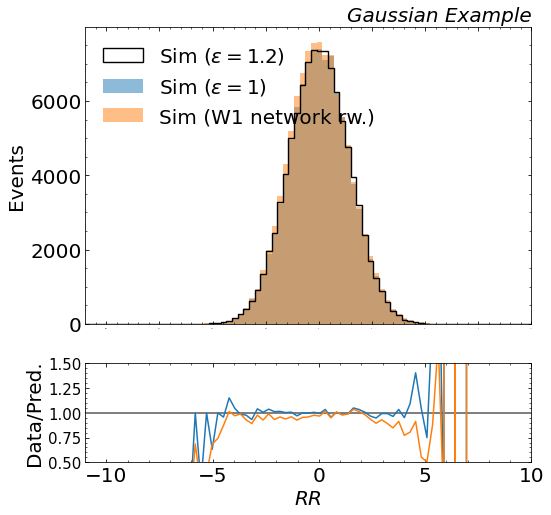

<Figure size 432x288 with 0 Axes>

In [77]:
# Test the trained W1 model

# w1_model_name_0 = 'w1_gaussian2D_deltaEpsilon0.8_2022-11-14'
w1_model_name_0 = 'w1_gaussian2D_deltaEpsilon0.2_2022-11-15'

w1_model_network_0 = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)

w1_model_analytic = w1_analytic(1, 0., 0., 0.8).double().to(dvc)

today = str(datetime.date.today())

R_test0 = np.concatenate((RL_test0, RR_test0), axis=1)
w1_test_ds = w0_dataset(T_test, R_test0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"Compare_RL_forW1network_{today}")
cpwr.add_data(RL_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"Compare_RR_forW1network_{today}")
cpwr.add_data(RR_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

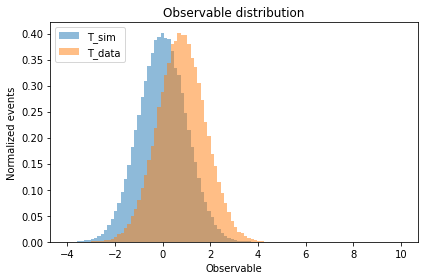

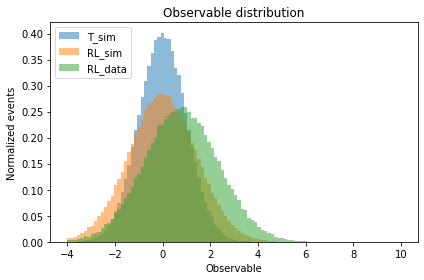

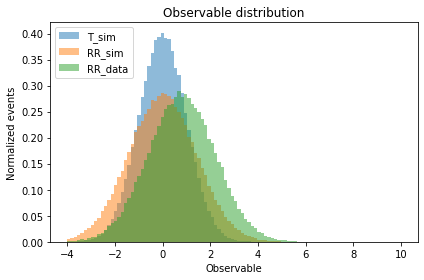

<Figure size 432x288 with 0 Axes>

In [36]:
# Generate data for W0 training (as well as theta)

Ndata = 100000
Nsim = 200000

mu_sim = 0
sigma_sim = 1
alpha_sim = 0
delta_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.8
sigma_data = 1
alpha_data = 0
delta_data = 1
beta_data = 0
epsilon_data = 1.2

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
RL_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)
RR_sim = np.random.normal(T_sim+alpha_sim,delta_sim)

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata).reshape(-1, 1)
RL_data = np.random.normal(T_data+beta_data,epsilon_data)
RR_data = np.random.normal(T_data+alpha_data,delta_data)

plt.hist(T_sim, range=(-4, 10), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(T_data, range=(-4, 10), density=True, bins=100, label="T_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(T_sim, range=(-4, 10), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(RL_sim, range=(-4, 10), density=True, bins=100, label="RL_sim", alpha=0.5)
plt.hist(RL_data, range=(-4, 10), density=True, bins=100, label="RL_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(T_sim, range=(-4, 10), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(RR_sim, range=(-4, 10), density=True, bins=100, label="RR_sim", alpha=0.5)
plt.hist(RR_data, range=(-4, 10), density=True, bins=100, label="RR_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

In [38]:
# Load W1 model and convert data into W0 datasets and data loaders
R_sim = np.concatenate((RL_sim, RR_sim), axis=1)
w0_ds = w0_dataset(T_sim, R_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

w1_model_name = 'w1_2_gaussian2D_deltaEpsilon0.2_2022-12-07'
w1RT_model_name = 'w1RT_gaussian2D_deltaEpsilon0.2_2022-12-07'
w1RT_model_network = torch.load(f'model/w1/{w1RT_model_name}.pth')
w1T_model_name = 'w1T_gaussian2D_deltaEpsilon0.2_2022-12-07'
w1T_model_network = torch.load(f'model/w1/{w1T_model_name}.pth')

R_data = np.concatenate((RL_data, RR_data), axis=1)
loss_fn = NLLLoss_2D(R_data, np.linspace(-5,5,20), np.linspace(-5,5,20), device=dvc)

[-0.0024027939643992084, 0.9983300972929328, tensor([0.0036, 0.0006], device='cuda:0', dtype=torch.float64), tensor([1.4124, 1.4138], device='cuda:0', dtype=torch.float64)]


In [39]:
# Create W0 model and train it (also theta)!

### PLEASE ENTER A NEW MODEL NAME FOR W0 AND THETA ###
today = str(datetime.date.today())
w0_model_name = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_{w1_model_name}_{today}'
theta_model_name = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_{w1_model_name}_{today}'

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001)
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

train_w0_2(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn, optimizer)#, optimizer1=optimizer_1)
torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1RT =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1T =====================
w1T_network(
  (linear_relu_stack): Sequential(

In [10]:
# Load W1 model and convert data into W0 datasets and data loaders
R_sim = np.concatenate((RL_sim, RR_sim), axis=1)
w0_ds = w0_dataset(T_sim, R_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

# w1_model_analytic = w1_analytic(1, 0., 0., 0.8).double().to(dvc)
# w1_model_name = "w1_analytic_gaussian"

# w1_model_name = 'w1_gaussian2D_deltaEpsilon0.8_2022-11-14'
w1_model_name = 'w1_gaussian2D_deltaEpsilon0.2_2022-11-15'
w1_model_network = torch.load(f'model/w1/{w1_model_name}.pth')

R_data = np.concatenate((RL_data, RR_data), axis=1)
loss_fn = NLLLoss_2D(R_data, np.linspace(-5,5,20), np.linspace(-5,5,20), device=dvc)

[-0.006442324469422341, 0.9979550828253441, tensor([-0.0102, -0.0054], device='cuda:0', dtype=torch.float64), tensor([1.4082, 1.4108], device='cuda:0', dtype=torch.float64)]


In [21]:
# Create W0 model and train it (also theta)!

### PLEASE ENTER A NEW MODEL NAME FOR W0 AND THETA ###
today = str(datetime.date.today())
w0_model_name = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_{w1_model_name}_{today}'
theta_model_name = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_{w1_model_name}_{today}'

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001)
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

train_w0(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1_model_network, theta_model, loss_fn, optimizer)#, optimizer1=optimizer_1)
torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1 =====================
w1_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=6, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Initial theta: 0.0
 Start optimizing the W0 model and theta
[Epoch   0] [Train_loss: -542694.193522] [Val

[Epoch  73] [Train_loss: -566626.755734] [Val_loss: -566724.359474] [Theta: 0.060513634234666824]
[Epoch  74] [Train_loss: -566632.016790] [Val_loss: -566728.920365] [Theta: 0.06133361905813217]
[Epoch  75] [Train_loss: -566637.170346] [Val_loss: -566733.617848] [Theta: 0.062159109860658646]
[Epoch  76] [Train_loss: -566642.455960] [Val_loss: -566738.904162] [Theta: 0.06298976391553879]
[Epoch  77] [Train_loss: -566647.990964] [Val_loss: -566744.940940] [Theta: 0.06382521241903305]
[Epoch  78] [Train_loss: -566653.530856] [Val_loss: -566751.371686] [Theta: 0.06466497480869293]
[Epoch  79] [Train_loss: -566658.723869] [Val_loss: -566757.622894] [Theta: 0.06550857424736023]
[Epoch  80] [Train_loss: -566663.492262] [Val_loss: -566763.334101] [Theta: 0.06635555624961853]
[Epoch  81] [Train_loss: -566668.052825] [Val_loss: -566768.493829] [Theta: 0.06720549613237381]
[Epoch  82] [Train_loss: -566672.607659] [Val_loss: -566773.208484] [Theta: 0.06805799901485443]
[Epoch  83] [Train_loss: -56

[Epoch 157] [Train_loss: -566965.896043] [Val_loss: -567056.388371] [Theta: 0.13253982365131378]
[Epoch 158] [Train_loss: -566969.066008] [Val_loss: -567059.555584] [Theta: 0.1333935558795929]
[Epoch 159] [Train_loss: -566972.224260] [Val_loss: -567062.715106] [Theta: 0.1342470496892929]
[Epoch 160] [Train_loss: -566975.372624] [Val_loss: -567065.871709] [Theta: 0.135100319981575]
[Epoch 161] [Train_loss: -566978.513064] [Val_loss: -567069.031855] [Theta: 0.1359533816576004]
[Epoch 162] [Train_loss: -566981.649238] [Val_loss: -567072.195133] [Theta: 0.13680624961853027]
[Epoch 163] [Train_loss: -566984.778066] [Val_loss: -567075.358457] [Theta: 0.13765889406204224]
[Epoch 164] [Train_loss: -566987.898709] [Val_loss: -567078.511888] [Theta: 0.13851132988929749]
[Epoch 165] [Train_loss: -566991.013144] [Val_loss: -567081.654335] [Theta: 0.13936355710029602]
[Epoch 166] [Train_loss: -566994.121314] [Val_loss: -567084.786257] [Theta: 0.14021556079387665]
[Epoch 167] [Train_loss: -566997.22

[Epoch 241] [Train_loss: -567210.897538] [Val_loss: -567307.206996] [Theta: 0.2033054381608963]
[Epoch 242] [Train_loss: -567213.599228] [Val_loss: -567310.023664] [Theta: 0.2041335552930832]
[Epoch 243] [Train_loss: -567216.298657] [Val_loss: -567312.836931] [Theta: 0.2049613744020462]
[Epoch 244] [Train_loss: -567218.994106] [Val_loss: -567315.641982] [Theta: 0.20578892529010773]
[Epoch 245] [Train_loss: -567221.684162] [Val_loss: -567318.439221] [Theta: 0.20661620795726776]
[Epoch 246] [Train_loss: -567224.371402] [Val_loss: -567321.228663] [Theta: 0.2074432075023651]
[Epoch 247] [Train_loss: -567227.054249] [Val_loss: -567324.013050] [Theta: 0.20826995372772217]
[Epoch 248] [Train_loss: -567229.733088] [Val_loss: -567326.795381] [Theta: 0.20909646153450012]
[Epoch 249] [Train_loss: -567232.407638] [Val_loss: -567329.577336] [Theta: 0.2099226862192154]
[Epoch 250] [Train_loss: -567235.079036] [Val_loss: -567332.354939] [Theta: 0.21074862778186798]
[Epoch 251] [Train_loss: -567237.74

[Epoch 325] [Train_loss: -567423.022825] [Val_loss: -567527.636326] [Theta: 0.27168527245521545]
[Epoch 326] [Train_loss: -567425.374573] [Val_loss: -567530.055755] [Theta: 0.27248361706733704]
[Epoch 327] [Train_loss: -567427.721877] [Val_loss: -567532.483097] [Theta: 0.27328166365623474]
[Epoch 328] [Train_loss: -567430.064827] [Val_loss: -567534.924241] [Theta: 0.2740793228149414]
[Epoch 329] [Train_loss: -567432.404323] [Val_loss: -567537.371651] [Theta: 0.2748766243457794]
[Epoch 330] [Train_loss: -567434.740425] [Val_loss: -567539.811398] [Theta: 0.2756735682487488]
[Epoch 331] [Train_loss: -567437.074084] [Val_loss: -567542.232176] [Theta: 0.2764701545238495]
[Epoch 332] [Train_loss: -567439.404148] [Val_loss: -567544.635751] [Theta: 0.27726641297340393]
[Epoch 333] [Train_loss: -567441.730948] [Val_loss: -567547.027749] [Theta: 0.2780623733997345]
[Epoch 334] [Train_loss: -567444.055512] [Val_loss: -567549.423494] [Theta: 0.2788580358028412]
[Epoch 335] [Train_loss: -567446.376

[Epoch 410] [Train_loss: -567609.396215] [Val_loss: -567721.909159] [Theta: 0.3381461203098297]
[Epoch 411] [Train_loss: -567611.418403] [Val_loss: -567724.025638] [Theta: 0.3389078974723816]
[Epoch 412] [Train_loss: -567613.437511] [Val_loss: -567726.137726] [Theta: 0.33966919779777527]
[Epoch 413] [Train_loss: -567615.452331] [Val_loss: -567728.246459] [Theta: 0.34043002128601074]
[Epoch 414] [Train_loss: -567617.461760] [Val_loss: -567730.350231] [Theta: 0.34119030833244324]
[Epoch 415] [Train_loss: -567619.466591] [Val_loss: -567732.448335] [Theta: 0.34195005893707275]
[Epoch 416] [Train_loss: -567621.467552] [Val_loss: -567734.541097] [Theta: 0.3427092432975769]
[Epoch 417] [Train_loss: -567623.464722] [Val_loss: -567736.632699] [Theta: 0.34346795082092285]
[Epoch 418] [Train_loss: -567625.458392] [Val_loss: -567738.724484] [Theta: 0.3442261219024658]
[Epoch 419] [Train_loss: -567627.448331] [Val_loss: -567740.814538] [Theta: 0.3449838161468506]
[Epoch 420] [Train_loss: -567629.44

[Epoch 495] [Train_loss: -567769.261232] [Val_loss: -567889.579507] [Theta: 0.40138232707977295]
[Epoch 496] [Train_loss: -567770.980250] [Val_loss: -567891.398649] [Theta: 0.40210476517677307]
[Epoch 497] [Train_loss: -567772.700912] [Val_loss: -567893.217308] [Theta: 0.40282654762268066]
[Epoch 498] [Train_loss: -567774.418458] [Val_loss: -567895.035012] [Theta: 0.4035479426383972]
[Epoch 499] [Train_loss: -567776.133225] [Val_loss: -567896.850609] [Theta: 0.40426892042160034]
[Epoch 500] [Train_loss: -567777.845339] [Val_loss: -567898.662517] [Theta: 0.4049895405769348]
[Epoch 501] [Train_loss: -567779.554403] [Val_loss: -567900.469933] [Theta: 0.40570980310440063]
[Epoch 502] [Train_loss: -567781.260032] [Val_loss: -567902.274047] [Theta: 0.4064296782016754]
[Epoch 503] [Train_loss: -567782.963659] [Val_loss: -567904.075530] [Theta: 0.40714919567108154]
[Epoch 504] [Train_loss: -567784.664854] [Val_loss: -567905.874125] [Theta: 0.4078683853149414]
[Epoch 505] [Train_loss: -567786.3

[Epoch 580] [Train_loss: -567905.855389] [Val_loss: -568033.673188] [Theta: 0.46143072843551636]
[Epoch 581] [Train_loss: -567907.350841] [Val_loss: -568035.241477] [Theta: 0.46212145686149597]
[Epoch 582] [Train_loss: -567908.843131] [Val_loss: -568036.802204] [Theta: 0.4628118574619293]
[Epoch 583] [Train_loss: -567910.332416] [Val_loss: -568038.365300] [Theta: 0.46350184082984924]
[Epoch 584] [Train_loss: -567911.819506] [Val_loss: -568039.934811] [Theta: 0.4641914665699005]
[Epoch 585] [Train_loss: -567913.304094] [Val_loss: -568041.501219] [Theta: 0.46488070487976074]
[Epoch 586] [Train_loss: -567914.786548] [Val_loss: -568043.056074] [Theta: 0.4655696153640747]
[Epoch 587] [Train_loss: -567916.266132] [Val_loss: -568044.599954] [Theta: 0.46625816822052]
[Epoch 588] [Train_loss: -567917.743296] [Val_loss: -568046.140213] [Theta: 0.4669463336467743]
[Epoch 589] [Train_loss: -567919.217994] [Val_loss: -568047.685575] [Theta: 0.4676341116428375]
[Epoch 590] [Train_loss: -567920.69001

[Epoch 665] [Train_loss: -568022.623305] [Val_loss: -568155.475453] [Theta: 0.5184568762779236]
[Epoch 666] [Train_loss: -568023.875456] [Val_loss: -568156.779101] [Theta: 0.5191064476966858]
[Epoch 667] [Train_loss: -568025.125406] [Val_loss: -568158.075866] [Theta: 0.519755482673645]
[Epoch 668] [Train_loss: -568026.372722] [Val_loss: -568159.365151] [Theta: 0.5204039812088013]
[Epoch 669] [Train_loss: -568027.616652] [Val_loss: -568160.652079] [Theta: 0.5210518836975098]
[Epoch 670] [Train_loss: -568028.857801] [Val_loss: -568161.940414] [Theta: 0.5216992497444153]
[Epoch 671] [Train_loss: -568030.096894] [Val_loss: -568163.227052] [Theta: 0.5223460793495178]
[Epoch 672] [Train_loss: -568031.332997] [Val_loss: -568164.505397] [Theta: 0.5229923725128174]
[Epoch 673] [Train_loss: -568032.566996] [Val_loss: -568165.778833] [Theta: 0.5236381888389587]
[Epoch 674] [Train_loss: -568033.797409] [Val_loss: -568167.051198] [Theta: 0.5242834687232971]
[Epoch 675] [Train_loss: -568035.024710] 

[Epoch 750] [Train_loss: -568119.914365] [Val_loss: -568255.695718] [Theta: 0.5718748569488525]
[Epoch 751] [Train_loss: -568120.954605] [Val_loss: -568256.765847] [Theta: 0.5724825859069824]
[Epoch 752] [Train_loss: -568121.991101] [Val_loss: -568257.835639] [Theta: 0.5730897784233093]
[Epoch 753] [Train_loss: -568123.025186] [Val_loss: -568258.901514] [Theta: 0.5736963152885437]
[Epoch 754] [Train_loss: -568124.056848] [Val_loss: -568259.967233] [Theta: 0.5743022561073303]
[Epoch 755] [Train_loss: -568125.086264] [Val_loss: -568261.023892] [Theta: 0.5749076008796692]
[Epoch 756] [Train_loss: -568126.112783] [Val_loss: -568262.075195] [Theta: 0.5755123496055603]
[Epoch 757] [Train_loss: -568127.136981] [Val_loss: -568263.127813] [Theta: 0.5761165022850037]
[Epoch 758] [Train_loss: -568128.158918] [Val_loss: -568264.185316] [Theta: 0.576720118522644]
[Epoch 759] [Train_loss: -568129.178648] [Val_loss: -568265.234806] [Theta: 0.5773231387138367]
[Epoch 760] [Train_loss: -568130.196400] 

[Epoch 835] [Train_loss: -568200.245398] [Val_loss: -568337.827295] [Theta: 0.6216728687286377]
[Epoch 836] [Train_loss: -568201.091918] [Val_loss: -568338.712801] [Theta: 0.6222347617149353]
[Epoch 837] [Train_loss: -568201.937424] [Val_loss: -568339.565827] [Theta: 0.6227961778640747]
[Epoch 838] [Train_loss: -568202.780038] [Val_loss: -568340.412782] [Theta: 0.6233570575714111]
[Epoch 839] [Train_loss: -568203.622308] [Val_loss: -568341.288865] [Theta: 0.6239174604415894]
[Epoch 840] [Train_loss: -568204.461302] [Val_loss: -568342.174157] [Theta: 0.6244774460792542]
[Epoch 841] [Train_loss: -568205.297613] [Val_loss: -568343.027203] [Theta: 0.6250368356704712]
[Epoch 842] [Train_loss: -568206.132808] [Val_loss: -568343.858384] [Theta: 0.6255956888198853]
[Epoch 843] [Train_loss: -568206.966013] [Val_loss: -568344.700531] [Theta: 0.6261540651321411]
[Epoch 844] [Train_loss: -568207.797185] [Val_loss: -568345.561632] [Theta: 0.626711905002594]
[Epoch 845] [Train_loss: -568208.625585] 

[Epoch 920] [Train_loss: -568265.012619] [Val_loss: -568404.134042] [Theta: 0.6674954295158386]
[Epoch 921] [Train_loss: -568265.702446] [Val_loss: -568404.825123] [Theta: 0.6680137515068054]
[Epoch 922] [Train_loss: -568266.390644] [Val_loss: -568405.530176] [Theta: 0.6685318350791931]
[Epoch 923] [Train_loss: -568267.077819] [Val_loss: -568406.245216] [Theta: 0.6690496802330017]
[Epoch 924] [Train_loss: -568267.763195] [Val_loss: -568406.932287] [Theta: 0.6695672273635864]
[Epoch 925] [Train_loss: -568268.446702] [Val_loss: -568407.608479] [Theta: 0.6700844168663025]
[Epoch 926] [Train_loss: -568269.128267] [Val_loss: -568408.309377] [Theta: 0.6706012487411499]
[Epoch 927] [Train_loss: -568269.808199] [Val_loss: -568409.008120] [Theta: 0.6711176633834839]
[Epoch 928] [Train_loss: -568270.486379] [Val_loss: -568409.691316] [Theta: 0.6716336607933044]
[Epoch 929] [Train_loss: -568271.161804] [Val_loss: -568410.365431] [Theta: 0.672149121761322]
[Epoch 930] [Train_loss: -568271.836182] 

In [22]:
# Just to check the fitted epsilon value from the optimization

print("mu data = 0.2, Delta epsilon = 0.8, fitted epsilon = 1.1776933312416076")
print("mu data = 0.8, Delta epsilon = 0.8, fitted epsilon = 1.200434398651123")
print(f"mu data = 0.8, Delta epsilon = 0.2, fitted epsilon = {theta_model().item()*0.2+1}")
# print(theta_model().item()*0.8+1)

mu data = 0.2, Delta epsilon = 0.8, fitted epsilon = 1.1776933312416076
mu data = 0.8, Delta epsilon = 0.8, fitted epsilon = 1.200434398651123
mu data = 0.8, Delta epsilon = 0.2, fitted epsilon = 1.1414368510246278


Fitted epsilon = 1.0062194425612687
[Test_loss: -567882.763099]


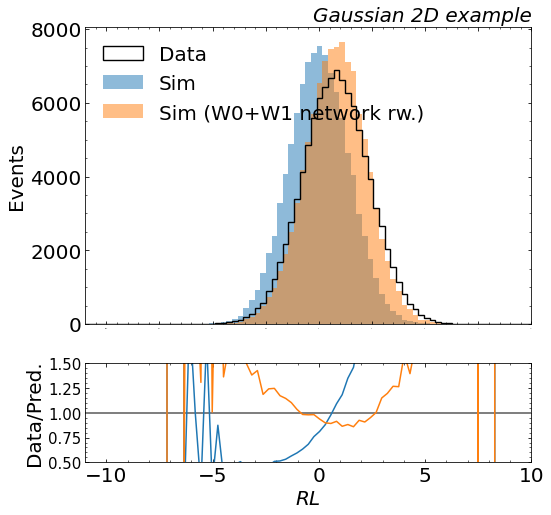

<Figure size 432x288 with 0 Axes>

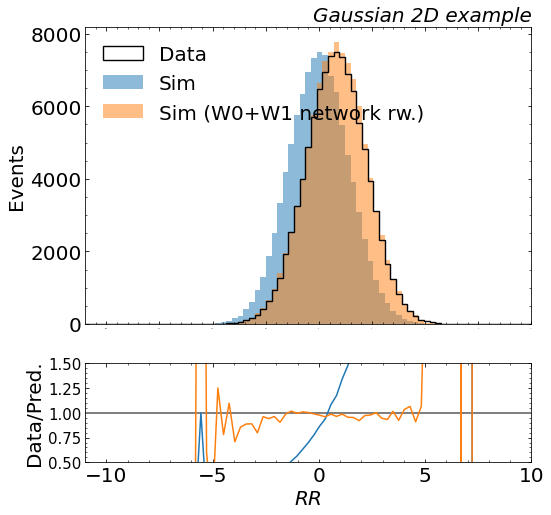

<Figure size 432x288 with 0 Axes>

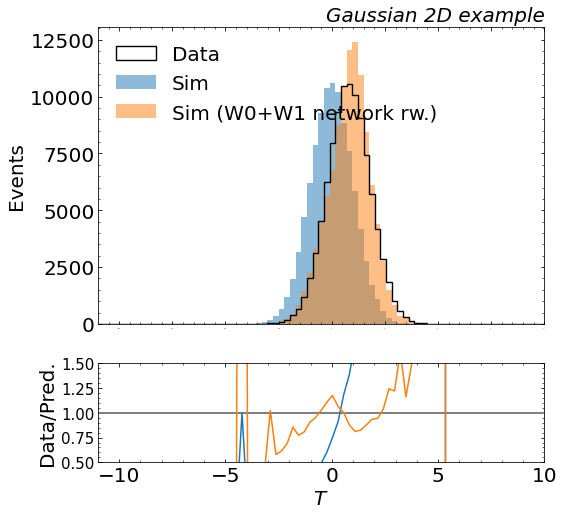

<Figure size 432x288 with 0 Axes>

In [41]:
# w0_model_network_0 = w0_model_network

# w0_model_name_0 = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_{w1_model_name}_2022-12-06'
# w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')

# theta_model_name_0 = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_{w1_model_name}_2022-12-06'
# theta_model_0 = torch.load(f'model/theta/{theta_model_name_0}.pth')

w0_model_network_0 = w0_model_network
theta_model_0 = theta_model

print(f"Fitted epsilon = {theta_model_0().item()*0.2+1}")

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0_2(w0_dataloader_test, w0_model_network_0, w1RT_model_network, w1T_model_network, theta_model_0, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"Gaussian2D_Compare_RL_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,0], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"Gaussian2D_Compare_RR_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,1], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False, save_name=f"Gaussian2D_Compare_T_{today}", header="Gaussian 2D example")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

Fitted epsilon = 1.1414368510246278
[Test_loss: -568454.507206]


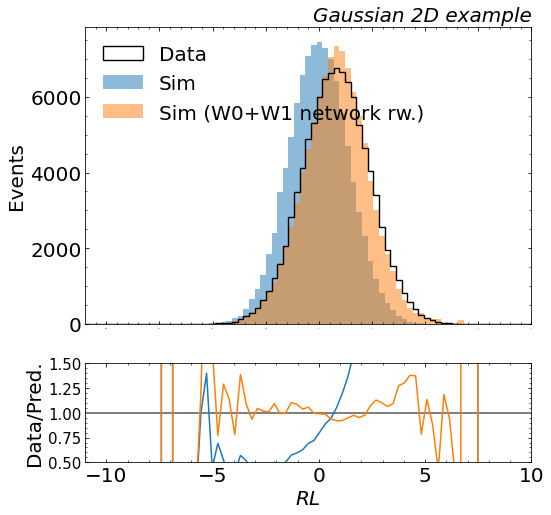

<Figure size 432x288 with 0 Axes>

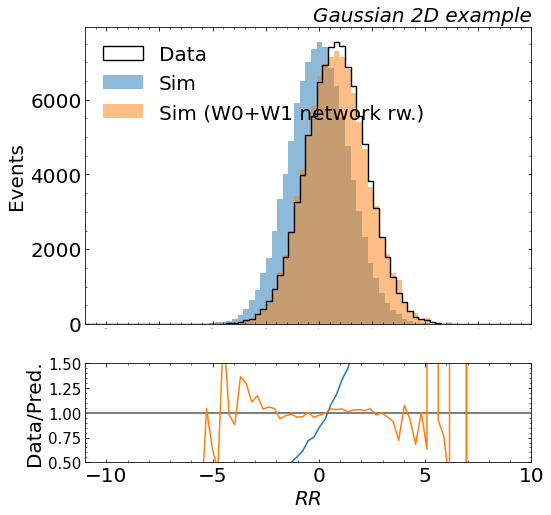

<Figure size 432x288 with 0 Axes>

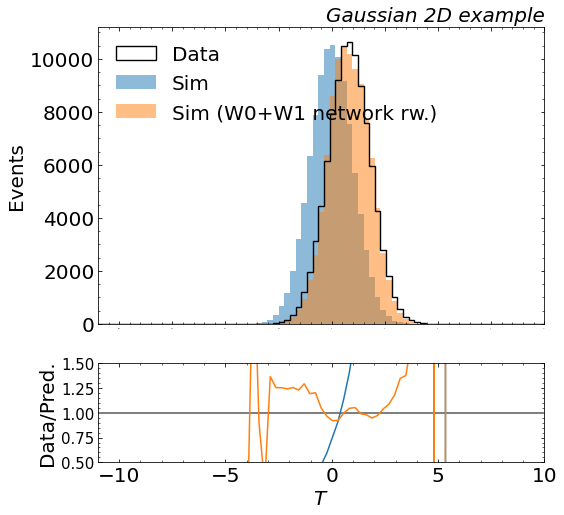

<Figure size 432x288 with 0 Axes>

In [23]:
# w0_model_network_0 = w0_model_network

w0_model_name_0 = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_{w1_model_name}_2022-12-06'
w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')

theta_model_name_0 = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_{w1_model_name}_2022-12-06'
theta_model_0 = torch.load(f'model/theta/{theta_model_name_0}.pth')

print(f"Fitted epsilon = {theta_model_0().item()*0.2+1}")

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1_model_network, theta_model_0, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"Gaussian2D_Compare_RL_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,0], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"Gaussian2D_Compare_RR_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,1], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False, save_name=f"Gaussian2D_Compare_T_{today}", header="Gaussian 2D example")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

Fitted epsilon = 1.200434398651123
[Test_loss: -568936.114192]


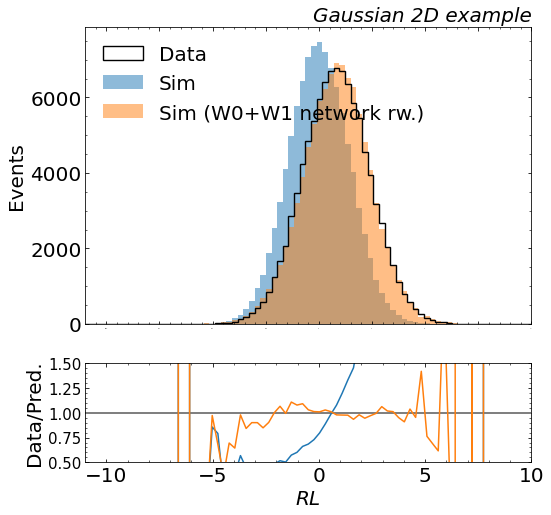

<Figure size 432x288 with 0 Axes>

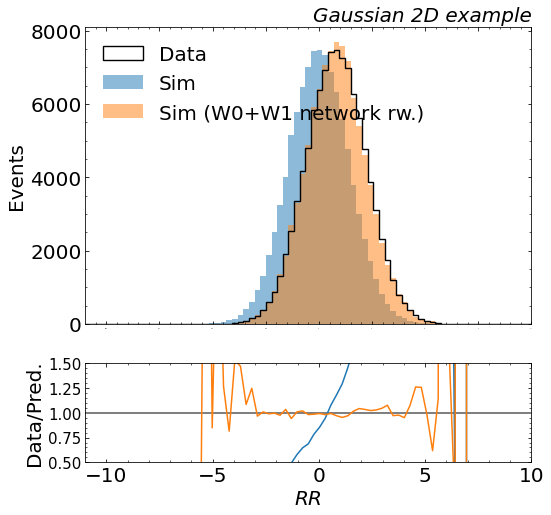

<Figure size 432x288 with 0 Axes>

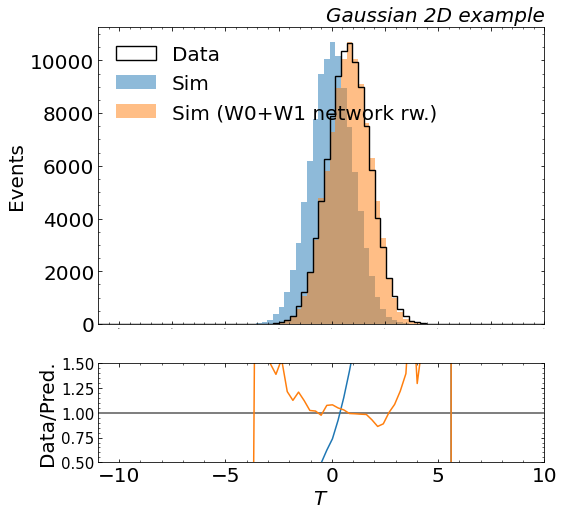

<Figure size 432x288 with 0 Axes>

In [17]:
w0_model_name_0 = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_{w1_model_name}_2022-11-14'
w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')

theta_model_name_0 = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_{w1_model_name}_2022-11-14'
theta_model_0 = torch.load(f'model/theta/{theta_model_name_0}.pth')

print(f"Fitted epsilon = {theta_model_0().item()*0.8+1}")

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1_model_network, theta_model_0, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"Gaussian2D_Compare_RL_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,0], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"Gaussian2D_Compare_RR_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,1], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False, save_name=f"Gaussian2D_Compare_T_{today}", header="Gaussian 2D example")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()